In [1]:
%%time
# Author: Michael Djaballah
# Last edited 01:15 AM July 6, 2020
# Last edited by: Michael Djaballah

import yfinance as yf
import pandas as pd
from datetime import datetime
import os
from time import sleep, time
from dateutil.relativedelta import relativedelta
import sklearn as sk
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from copy import deepcopy

CPU times: user 767 ms, sys: 226 ms, total: 993 ms
Wall time: 1.34 s


In [2]:
'''
Variable ordering
- Portfolio
- ticker(s)
- features
- model
- date
- date format
- historical depth
- training depth
- start
- end
- interval
- data path
'''

'\nVariable ordering\n- Portfolio\n- ticker(s)\n- features\n- model\n- date\n- date format\n- historical depth\n- training depth\n- start\n- end\n- interval\n- data path\n'

In [3]:
data_path = 'data/'
start = '2000-01-01'
interval = '1mo'

In [4]:
# Functions to maintain and call the S&P 500 from a current date
# Author Michael Djaballah
# Time last edited: 01:47 AM June 21, 2020
# Last edited by: Michael Djaballah

# Takes no input
# Output is newly saved CSV's containing the current makeup of the S&P 500 
# and its historical additions and removals
# data_path is changeable depending on desired save location
def get_snp_store(data_path='data/'):
    curr_raw = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    
    curr = curr_raw[0]
    hist = curr_raw[1]
    
    new_hist = pd.DataFrame(hist['Date'])
    new_hist['Added'] = hist['Added', 'Ticker']
    new_hist['Removed'] = hist['Removed', 'Ticker']
    
    os.makedirs(data_path, exist_ok=True)
    
    curr.to_csv(data_path + 'snp_current.csv', index=False)
    new_hist.to_csv(data_path + 'snp_hist.csv', index=False)
    return None


# Input: a date in string form with its corresponding format:
# Ex: 'January 1, 2020', '%B %d, %Y'
# Output: a list containing the S&P 500 at the input date
def build_snp(date, date_format='%Y-%m-%d', data_path='data/'):
#     get_snp_store(data_path=data_path)
    
    date_format2 = '%B %d, %Y'
    
    curr = pd.read_csv(data_path + 'snp_current.csv')
    hist = pd.read_csv(data_path + 'snp_hist.csv')
    
    start_date = datetime.strptime(date, date_format)
    
    snp_set = set(curr['Symbol'])
    
    for i in range(len(hist)):
        temp_date = datetime.strptime(hist.iloc[i]['Date'], date_format2)
        if temp_date < start_date:
            break

        tb_removed = hist.iloc[i]['Added']
        tb_added = hist.iloc[i]['Removed']

        if tb_removed in snp_set:
            snp_set.remove(tb_removed)
        if not type(tb_added) == float:
            snp_set.add(tb_added)
    
    return list(snp_set)

In [5]:
# Functions to obtain data from yfinance
# Author Michael Djaballah
# Time last edited: 01:47 AM June 21, 2020
# Last edited by: Michael Djaballah

# Takes a list of tickers as strings
# Output is newly saved CSV's with one CSV per company with daily data
# Saved in specific directory
# data_path is changeable depending on desired save location
def get_data(tickers, start='2000-01-01', data_path='data/', get_new=False):
    interval = '1d'
    prefix = interval + '/'
    
    os.makedirs(data_path + prefix, exist_ok=True)
    
    if get_new:
        curr_tickers = set()
    else:
        curr_tickers = set(os.listdir(data_path + prefix))
    
    for ticker in tickers:
        ticker_label = ticker + '.csv'
        
        if ticker_label not in curr_tickers:
            temp_ticker = yf.Ticker(ticker)
            temp_hist = temp_ticker.history(start=start, interval=interval)
            temp_hist.reset_index(inplace=True)
            temp_hist.dropna(axis=0, inplace=True)
            temp_hist.to_csv(data_path + prefix + ticker_label, index=False)
            sleep(.5)
            
    return None


# Input: Ticker 
# Output: Takes daily data already downloaded and extracts monthly data
# To be used with a set of other functions for intervals named "build_" + interval
# 
def build_1mo(ticker, data_path='data/'):
    if '.csv' in ticker:
        ticker_df = pd.read_csv(data_path + '1d/' + ticker)
    else:
        ticker_df = pd.read_csv(data_path + '1d/' + ticker + '.csv')
        
    date_format = '%Y-%m-%d'
    
    # These are hardcoded and should be more changed if more flexibility is desired
    data_start = '2000-01-01'
    data_end = '2020-05-01'
    
    month_list = list(pd.date_range(data_start, data_end, freq='MS').strftime(date_format))
    
    # Not currently coded for Dividends or Stock Splits
    months_dict = {
        'Date' : [], 
        'Open' : [], 
        'High' : [], 
        'Low' : [], 
        'Close' : [], 
        'Volume' : []
    }
    
    for start in month_list:
        end = datetime.strptime(start, date_format) + relativedelta(months=1) - relativedelta(days=1)
        end = datetime.strftime(end, date_format)
        
        month_df = ticker_df.set_index('Date')[start:end].reset_index()
        
        if len(month_df) > 0:
            months_dict['Date'].append(start)
            months_dict['Open'].append(month_df.iloc[0]['Open'])
            months_dict['High'].append(max(month_df['High']))
            months_dict['Low'].append(min(month_df['Low']))
            months_dict['Close'].append(month_df.iloc[-1]['Close'])
            months_dict['Volume'].append(sum(month_df['Volume']))
    
    months_df = pd.DataFrame.from_dict(months_dict)
    return months_df


# Input: Interval (string) that is in the list of approved
# Output: Data extracted from previously downloaded daily data in 
# a similarly named directory
# The commented out interval set is to be developed 
def build_data(interval, data_path='data/'):
#     interval_set = {'1mo', '5d', '1wk', '3mo'}
    interval_set = {'1mo'}
    if interval not in interval_set:
        print('Invalid interval')
        return -1
    
    prefix = interval + '/'
    
    os.makedirs(data_path + prefix, exist_ok=True)
    
    ticker_labels = os.listdir(data_path + '1d/')
    
    interval_function = globals()['build_' + interval]
    
    for ticker_label in ticker_labels:
        ticker_df = interval_function(ticker_label)
        ticker_df.to_csv(data_path + prefix + ticker_label, index=False)
    return None

In [6]:
# Functions to manipulate and extract desired data from data saved with "get_data"
# Author Michael Djaballah
# Time last edited: 01:47 AM June 21, 2020
# Last edited by: Michael Djaballah


# Takes a ticker as a string
# Output is either a dataframe with desired data, or False, indicating that there was not enough data to build with the desired offset
# data_path is changeable depending on desired save location
def check_ticker(ticker, offset, interval = '1mo', data_path='data/'):
    prefix = interval + '/'
    ticker_df = pd.read_csv(data_path + prefix + ticker + '.csv')
    if len(ticker_df) >= offset:
        return ticker_df
    return False


# Takes a list of tickers as strings, the test depth and historical depth
# Output is a dictionary of data frames: key = ticker string, value = dataframe
# data_path is changeable depending on desired save location
def build_portfolio(tickers, hist_depth, train_depth, start='2000-01-01', interval='1mo', data_path='data/', offset=True, get_new=False):
    if type(offset) == bool:
        offset = train_depth + hist_depth + 60 + 6
        
    prefix = interval + '/'
    
    get_data(tickers, data_path=data_path, start=start, get_new=get_new)
    
    ticker_dict = {}
    
    for ticker in tickers:
        ticker_df = check_ticker(ticker, offset, data_path=data_path)
        if type(ticker_df) != bool:
            ticker_dict[ticker] = ticker_df
    
    return ticker_dict


# Takes a portfolio (from 'build_portfolio'), a desired ticker, date desired to predict on, depth desired, and features desired
# Output is a dataframe with one row or the desired features from previous dates
# Can change 'keep_pred' to True if training or False if predicting
# Target value is present in 'Target' column if 'keep_pred' = True
def build_feature_vector(portfolio, ticker, features, date, hist_depth, target='Close', keep_pred=True):
    ticker_df = portfolio[ticker]
    
    start_date_dt = datetime.strptime(date, '%Y-%m-%d') - relativedelta(months=hist_depth)
    start_date = start_date_dt.strftime('%Y-%m-%d')
    
    feature_df = ticker_df.set_index('Date')[start_date:date].reset_index(drop=True)[features]
    
    new_df_dict = {}
    
    for i in range(len(feature_df)):
        for col in feature_df.columns:
            if i < len(feature_df) - 1:
                new_df_dict[col + ' ' + str(i + 1)] = [feature_df[col].iloc[i]]
            elif col == target:
                if keep_pred:
                    new_df_dict['Target'] = [feature_df[col].iloc[i]]
                    
    new_df = pd.DataFrame.from_dict(new_df_dict)
    
    if keep_pred:
        new_df = new_df[[col for col in new_df.columns if col not in {'Target'}] + ['Target']]
    
    return new_df

In [7]:
# 
# Author Michael Djaballah
# Time last edited: 01:15 AM July 6, 2020
# Last edited by: Michael Djaballah

# Input: portfolio, features, date that the training is to go to, both depths
# Output: dataframe with all features for all training months for the portfolio
# 
# 
def build_train_df(portfolio, features, date, hist_depth, train_depth, target='Close'):    
    tickers = portfolio.keys()
    
    vector_list = []
    for ticker in tickers:
        for i in range(train_depth):
            train_start_dt = datetime.strptime(date, '%Y-%m-%d') - relativedelta(months=(1+i))
            train_start = train_start_dt.strftime('%Y-%m-%d')
            vector_list.append(build_feature_vector(portfolio, ticker, features, train_start, hist_depth, target=target))
            
    feature_df = pd.concat(vector_list)
    return feature_df.reset_index(drop=True)


# Input: portfolio, features, date, historical depth
# Output: dataframe missing y's to predict with and an index list to show which ticker is where in the dataframe
# Returns in a tuple that must be unpacked
# 
def build_test_df(portfolio, features, date, hist_depth, target='Close'):
    tickers = portfolio.keys()
    
    vector_list = []
    index_list = []
    for ticker in tickers:
        vector_list.append(build_feature_vector(portfolio, ticker, features, date, hist_depth, target=target, keep_pred=False))
        index_list.append(ticker)
        
    test_df = pd.concat(vector_list)
    return test_df.reset_index(drop=True), index_list


# Input: portfolio, desired list of tickers to get returns for, and the date of those returns
# Output: list of returns for those tickers
# 
# 
def build_returns(portfolio, tickers, date):
    returns = []
    for ticker in tickers:
        temp_ticker_dict = portfolio[ticker].set_index('Date').loc[date]
        returns.append((temp_ticker_dict['Close'] - temp_ticker_dict['Open'])/temp_ticker_dict['Open'])
    return returns


# Input: Portfolio, ticker, and desired date 
# Output: Whether or not the data has the specific date
# This is to tell if a certain ticker exists on a certain date
# 
def check_date(portfolio, ticker, date):
    dates = set(portfolio[ticker]['Date'])
    return date in dates


# Input: Portfolio, date
# Output: None, this directly edits the portfolio
# This can be changed to reduce side effects, but it is used 
# to remove tickers that are no longer needed moving forward in a backtest
def clean_portfolio(portfolio, date):
    tickers = list(portfolio.keys())
    bad_tickers = []
    for ticker in tickers:
        if not check_date(portfolio, ticker, date):
            bad_tickers.append(ticker)
    for bad_ticker in bad_tickers:
        del portfolio[bad_ticker]
    return None


# ALERT: This function has been depracated as direct access to the scaler is needed for interpretation
# Input: Dataframe
# Output: Dataframe scaled to standard
# 
# 
# def build_scaled_df(dataframe):
#     scaler = StandardScaler()
#     scaled_array = scaler.fit_transform(dataframe)
#     scaled_dataframe = pd.DataFrame(scaled_array, columns=dataframe.columns)
#     return scaled_dataframe


# Input: Portfolio, date
# Output: Dataframe of 'Close 1', the close of the previous month for the whole portfolio
# 
# 
def build_previous_close(portfolio, date):
    tickers = portfolio.keys()
    
    vector_list = []
    index_list = []
    for ticker in tickers:
        vector_list.append(build_feature_vector(portfolio, ticker, ['Close'], date, hist_depth=1, keep_pred=False))
        index_list.append(ticker)
        
    df = pd.concat(vector_list)
    return df.reset_index(drop=True)


# Input: Portfolio, model, date, features, and depths
# Output: 
# 
# 
def build_machine(portfolio, features, model, date, hist_depth, train_depth, use_scaling=True, target='Close'):
    train_df = build_train_df(portfolio, features, date, hist_depth, train_depth, target=target)
    
    X = train_df.loc[:, train_df.columns != 'Target'].values
    y = train_df['Target'].values
    
    model.fit(X, y)
    
    test_df, tickers = build_test_df(portfolio, features, date, hist_depth, target=target)
    X_test = test_df.values
    
    predicted_returns = model.predict(X_test)
    
    previous_close = build_previous_close(portfolio, date)['Close 1'].values
        
    if use_scaling:
        predicted_returns = (predicted_returns - previous_close)/previous_close
    
    predicted_returns = list(predicted_returns)
    
    returns_dict = {}
    
    for i in range(len(tickers)):
        returns_dict[tickers[i]] = predicted_returns[i]
    
    return returns_dict


# Input: Returns dictionary and fixed long short parameters
# Output: Allocation dictionary for long and short tickers
# 
# 
def fixed_long_short(returns_dict, long=15, short=0):
    allocation = {
        'long' : [], 
        'short' : []
    }
    top = sorted(returns_dict.items(), key=lambda x: x[1])[::-1]
    sorted_tickers = [x[0] for x in top]
    
    allocation['long'] = sorted_tickers[:long]
    if short == 0:
        allocation['short'] = []
    else:
        allocation['short'] = sorted_tickers[-1 * short:]
#     print('long: ')
#     print(allocation['long'])
#     print('short: ')
#     print(allocation['short'])
    
    return allocation
    

# Input: all things needed to build a machine with a date range to test
# Output: per date average returns as determined by the model
# 
# 
def backtest(portfolio, features, model, hist_depth, train_depth, start_date, end_date, 
             allocation_builder=fixed_long_short, params={}, blacklist=set(), 
             target='Close', use_scaling=True):
    
    months = list(pd.date_range(start_date, end_date, freq='MS').strftime('%Y-%m-%d'))
    
    for ticker in blacklist:
        if ticker in portfolio:
            del portfolio[ticker]
            
    portfolio = deepcopy(portfolio)
    
    overall_returns = []
    specific_returns = []
    for month in months:
        start_time = time()
        
        clean_portfolio(portfolio, month)
        
        returns_dict = build_machine(portfolio, features, model, month, hist_depth, train_depth, target=target, use_scaling=use_scaling)
    
        allocation = allocation_builder(returns_dict, **params)
        
        long_returns = build_returns(portfolio, allocation['long'], month)
        short_returns = build_returns(portfolio, allocation['short'], month)
        short_returns = [short_return * -1 for short_return in short_returns]
        total_returns = long_returns + short_returns
        average_returns = sum(total_returns)/len(total_returns)
        
        
        specific_returns_dict = {'long': {}, 'short': {}}
        for i in range(len(allocation['long'])):
            specific_returns_dict['long'][allocation['long'][i]] = long_returns[i]

        for i in range(len(allocation['short'])):
            specific_returns_dict['short'][allocation['short'][i]] = short_returns[i]
            
        specific_returns.append(specific_returns_dict)
        overall_returns.append(average_returns)
        
        print(month, round(average_returns, 5), round(time() - start_time, 2))
    
    return overall_returns, specific_returns

In [8]:
# METRICS
# Author Michael Djaballah
# Time last edited: 05:31 PM July 12, 2020
# Last edited by: Michael Djaballah

# Sharpe Ratio
# Total Return DONE
# Volatility DONE
# Maximum Drawdown DONE 
# Lowest balance DONE
# Annualized Returns DONE

def cumulative_returns(returns):
    starting_capital = 1
    historical_returns = [starting_capital]
    for i in range(len(returns)):
        starting_capital *= (returns[i] + 1)
        historical_returns.append(starting_capital)
    return historical_returns


def total_return(cumulative_returns):
    return cumulative_returns[-1]


def return_volatility(returns):
    return np.std(returns)
    

def max_drawdown(cumulative_returns):
    drawdowns = []
    for i in range(len(cumulative_returns)):
        for j in range(i+1, len(cumulative_returns)):
            drawdowns.append((cumulative_returns[i] - cumulative_returns[j])/cumulative_returns[i])
    return max(drawdowns)


def min_amount(cumulative_returns):
    return min(cumulative_returns)


def annualized_returns(returns,  unit=1/12, tot_return=None):
    if type(tot_return) != float:
        cumul_returns = cumulative_returns(returns)
        tot_return = total_return(cumul_returns)
    years = len(returns) * unit
    return tot_return**(1/years)


def universe_backtest(portfolio, start_date, end_date):
    months = list(pd.date_range(start_date, end_date, freq='MS').strftime('%Y-%m-%d'))
    
    returns = []
    
    portfolio = deepcopy(portfolio)
    
    for month in months:
        clean_portfolio(portfolio, month)
        monthly_returns = build_returns(portfolio, list(portfolio.keys()), month)
        returns.append(sum(monthly_returns)/len(monthly_returns))
    return returns

In [9]:
%%time
# Took 2 secs
# get_snp_store()
universe = build_snp('2015-01-01')

CPU times: user 52.6 ms, sys: 2.19 ms, total: 54.7 ms
Wall time: 53.2 ms


In [10]:
%%time
# Took 13 mins 20 secs
# get_data(universe)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


In [11]:
%%time
# Took 2 min 41 secs for S&P 2015-01-01
# build_data('1mo')

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs


In [12]:
hist_depth = 18
train_depth = 4
features = ['Close', 'Volume']
start_date = '2015-01-01'
end_date = '2019-12-01'
params = {
    'long' : 15, 
    'short' : 3
}

In [13]:
%%time
port2 = build_portfolio(universe, hist_depth, train_depth)
print(len(port2.keys()))

431
CPU times: user 929 ms, sys: 63.7 ms, total: 993 ms
Wall time: 1.17 s


In [14]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [15]:
rfr = RandomForestRegressor(n_estimators=100, random_state=410, n_jobs=-1)
# rfr = GradientBoostingRegressor(n_estimators=1000, random_state=407)

In [16]:
%%time
results, specific_results = backtest(port2, features, rfr, hist_depth, train_depth, start_date, end_date, params=params)

2015-01-01 -0.23644 15.77
2015-02-01 0.07498 16.21
2015-03-01 -0.05092 16.42
2015-04-01 -0.00262 16.11
2015-05-01 0.04035 16.29
2015-06-01 -0.07162 16.11
2015-07-01 -0.07179 16.19
2015-08-01 0.2438 16.17
2015-09-01 0.00012 15.98
2015-10-01 0.28349 16.1
2015-11-01 0.0148 15.97
2015-12-01 -0.03124 16.0
2016-01-01 -0.05351 16.01
2016-02-01 0.03478 15.95
2016-03-01 0.31149 15.89
2016-04-01 0.02938 16.12
2016-05-01 0.06111 16.11
2016-06-01 0.03063 15.87
2016-07-01 0.07431 15.84
2016-08-01 0.0325 15.77
2016-09-01 0.00637 15.97
2016-10-01 0.0068 16.03
2016-11-01 0.10376 16.92
2016-12-01 -0.03306 15.79
2017-01-01 0.03687 16.04
2017-02-01 0.01574 15.79
2017-03-01 -0.00507 16.11
2017-04-01 -0.04941 15.88
2017-05-01 -0.07491 15.97
2017-06-01 -0.00381 15.99
2017-07-01 -0.00375 15.97
2017-08-01 -0.04607 15.93
2017-09-01 0.0722 15.85
2017-10-01 0.00379 15.84
2017-11-01 0.00706 15.86
2017-12-01 0.00264 15.84
2018-01-01 0.04392 15.91
2018-02-01 -0.02459 15.69
2018-03-01 0.11131 15.82
2018-04-01 0.0649

In [17]:
cumul_port = cumulative_returns(results)
vol_port = return_volatility(results)
tot_port = total_return(cumul_port)
draw_port = max_drawdown(cumul_port)
min_port = min_amount(cumul_port)
ann_port = annualized_returns(results)
# print('Cumulative: ', cumul_spy)
print('Vol: ', vol_port)
print('Total: ', tot_port)
print('Max draw: ', draw_port)
print('Min: ', min_port)
print('Ann ret: ', ann_port)

Vol:  0.08515540437602809
Total:  2.1893288998182796
Max draw:  0.3034449256778442
Min:  0.6965550743221558
Ann ret:  1.1696669049892157


In [18]:
%%time
spy_ret = universe_backtest(port2, start_date=start_date, end_date=end_date)
cumul_spy = cumulative_returns(spy_ret)
vol_spy = return_volatility(spy_ret)
tot_spy = total_return(cumul_spy)
draw_spy = max_drawdown(cumul_spy)
min_spy = min_amount(cumul_spy)
ann_spy = annualized_returns(spy_ret)
# print('Cumulative: ', cumul_spy)
print('Vol: ', vol_spy)
print('Total: ', tot_spy)
print('Max draw: ', draw_spy)
print('Min: ', min_spy)
print('Ann ret: ', ann_spy)

Vol:  0.03818199410021343
Total:  1.539942740261293
Max draw:  0.1698370355018457
Min:  0.9432066109530195
Ann ret:  1.090186788130621
CPU times: user 16.5 s, sys: 56.6 ms, total: 16.5 s
Wall time: 16.6 s


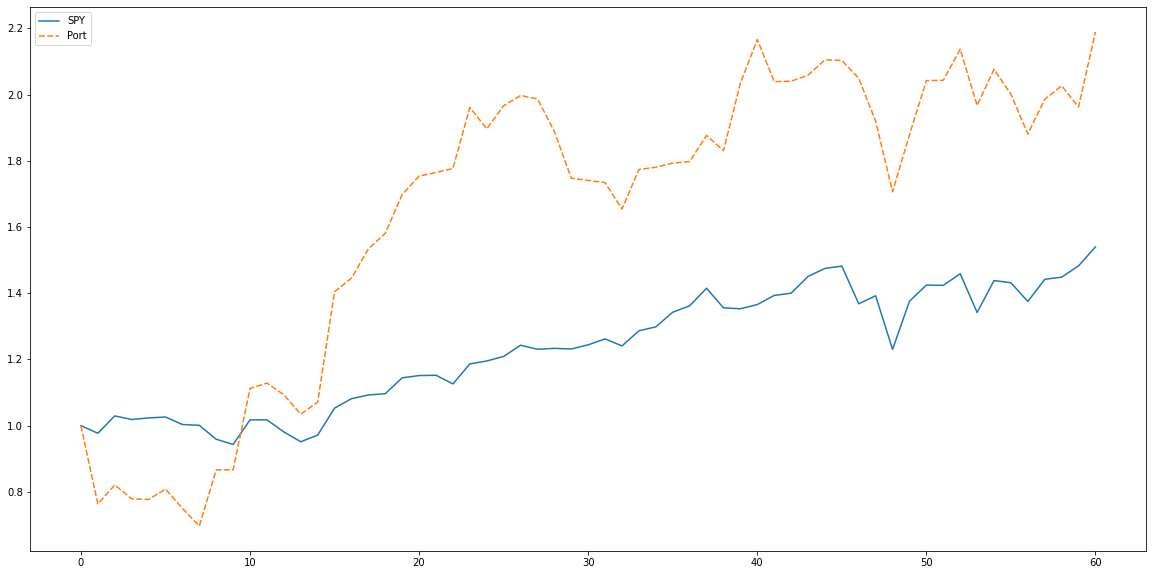

In [20]:
df_dict = {'SPY': cumul_spy, 'Port':cumul_port}
compare_df = pd.DataFrame.from_dict(df_dict)

fig_dims = (20,10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(data=compare_df)

In [21]:
months = list(pd.date_range(start_date, end_date, freq='MS').strftime('%Y-%m-%d'))
month_dict = {}
for i in range(len(months)):
    month_dict[months[i]] = i

In [37]:
suspect_month = '2019-01-01'

In [38]:
specific_results[month_dict[suspect_month]]

{'long': {'CHK': 0.425,
  'FTR': -0.14529914529914525,
  'JEF': 0.2131681877444589,
  'AVP': 0.5743243243243243,
  'QEP': 0.5063757016989476,
  'THC': 0.3034973325429755,
  'PBI': 0.23248871279830471,
  'AMZN': 0.17303439803439802,
  'DNR': 0.23030303030303026,
  'MU': 0.23290322580645156,
  'IVZ': 0.1095334685598378,
  'SYK': 0.13916449086161894,
  'UNM': 0.2191323692992215,
  'GAS': 0.019744483159117306,
  'ISRG': 0.11531416400425983},
 'short': {}}

In [42]:
port2['THC'].tail(30)

,Date,Open,High,Low,Close,Volume
215,2017-12-01,14.04,15.84,12.45,15.16,58920000
216,2018-01-01,15.25,19.69,14.50,18.88,54452700
217,2018-02-01,18.77,22.00,16.94,20.60,46106100
218,2018-03-01,20.75,25.24,20.41,24.25,52939100
219,2018-04-01,24.16,25.00,22.66,23.94,37853500
220,2018-05-01,25.10,37.52,24.83,35.43,54575800
221,2018-06-01,35.53,38.81,32.11,33.57,30378800
222,2018-07-01,33.37,39.74,32.82,37.63,28901400
223,2018-08-01,37.58,39.39,31.25,33.72,36968600
224,2018-09-01,33.68,34.19,27.21,28.46,20242000


In [ ]:
# For hist=12, train=3, took 7s
# %%time
# build_train_df(port2, features, '2015-01-01', hist_depth, train_depth)

In [ ]:
# For hist=12, train=3, took 2s
# %%time
# test_df, ticker_list = build_test_df(port2, features, '2015-01-01', hist_depth)

In [77]:
# starting_capital = 100
# historical = [starting_capital]
# for i in range(len(results)):
#     starting_capital *= (results[i] + 1)
#     historical.append(starting_capital)

In [78]:
# historical[-1], (historical[-1]/100)**(1/5), min(historical)

(272.54411874587106, 1.2220454628915778, 66.82568275184586)

In [79]:
# spy = yf.Ticker('SPY').history(period='max', interval='1mo').reset_index().dropna()
# port3 = {'SPY': spy}
# months = list(pd.date_range(start_date, end_date, freq='MS').strftime('%Y-%m-%d'))

# starting_capital = 100
# historical_spy = [starting_capital]
# for month in months:
#     returns = build_returns(port3, ['SPY'], month)[0]
#     starting_capital *= (returns + 1)
#     historical_spy.append(starting_capital)
    
# df_dict = {'SPY': historical_spy, 'Port':historical}
# compare_df = pd.DataFrame.from_dict(df_dict)

In [80]:
# historical_spy[-1], (historical_spy[-1]/100)**(1/5), min(historical_spy)

(149.72619165922305, 1.0840755652449479, 93.8068232860004)